##preprocessing

In [1]:
pip install pandas_ta

In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import missingno as msno
import keras
import pandas_ta as ta

In [3]:
ibm_df=pd.read_csv('/content/IBM_weekly.csv', sep=',', header=0)
ibm_df['Date'] = pd.to_datetime(ibm_df.Date)

ibm_df_subset=ibm_df[ibm_df['Close']<ibm_df['Low']]

ibm_df_subset.loc[ibm_df_subset['Date']<=pd.to_datetime('2021-11-04'),['Open', 'High', 'Low']]=ibm_df_subset.loc[ibm_df_subset['Date']<=pd.to_datetime('2021-11-04'),['Open', 'High', 'Low']]/1.046

# adjust for the 1999-05-27 split, plus the Open and High at 1999-05-30, which are an anomaly in the dataset
ibm_df_subset.loc[ibm_df_subset['Date']<=pd.to_datetime('1999-05-27'),['Open', 'High', 'Low']]=ibm_df_subset.loc[ibm_df_subset['Date']<=pd.to_datetime('1999-05-27'),['Open', 'High', 'Low']]/2
ibm_df_subset.loc[ibm_df_subset['Date']==pd.to_datetime('1999-05-30'),['Open', 'High']]=ibm_df_subset.loc[ibm_df_subset['Date']==pd.to_datetime('1999-05-30'),['Open', 'High']]/2

# adjust for the 1997-05-28 split, plus the Open and High at 1997-06-01, which are an anomaly in the dataset
ibm_df_subset.loc[ibm_df_subset['Date']<=pd.to_datetime('1997-05-28'),['Open', 'High', 'Low']]=ibm_df_subset.loc[ibm_df_subset['Date']<=pd.to_datetime('1997-05-28'),['Open', 'High', 'Low']]/2
ibm_df_subset.loc[ibm_df_subset['Date']==pd.to_datetime('1997-06-01'),['Open', 'High']]=ibm_df_subset.loc[ibm_df_subset['Date']==pd.to_datetime('1997-06-01'),['Open', 'High']]/2

from sklearn.preprocessing import StandardScaler, MinMaxScaler

#scaler
scaler = StandardScaler()
scaler2 = MinMaxScaler()

#standardization of the prices
ibm_df[['Close', 'Open', 'Low', 'High']] = scaler.fit_transform(ibm_df[['Close', 'Open', 'Low', 'High']])
ibm_df.loc[ibm_df['Volume']>0, ['Volume']] = scaler2.fit_transform(ibm_df.loc[ibm_df['Volume']>0, ['Volume']])

In [4]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],1))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model



In [5]:
ibm_df.loc[0:5,'Close'] #cambio indicizzazione su python

0   -1.845263
1   -1.834125
2   -1.829844
3   -1.840550
4   -1.838408
5   -1.845691
Name: Close, dtype: float64

## PRIMA ARCHITETTURA

In [6]:
splitlimit = int(len(ibm_df) * 0.8)
ibm_df_train_set = ibm_df.loc[:splitlimit,:]
ibm_df_test_set = ibm_df.loc[splitlimit:,:]

X_train=[]
y_train =[]
df_days=ibm_df_train_set.shape[0]

for x in range(5, df_days): #prendo intanto una finestra di 5 settimane
  X_train.append(ibm_df.loc[x-5:x-1,'Close'])
  y_train.append(ibm_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))


X_test=[]
y_test =[]

for x in range(df_days, ibm_df.shape[0]): #prendo intanto una finestra di 5 settimane
  X_test.append(ibm_df.loc[x-5:x-1,'Close'])
  y_test.append(ibm_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [7]:
#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 5, 50)             0         
                                                                 
 dense (Dense)               (None, 5, 1)              51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/10
42/42 [==============================] - 11s 95ms/step - loss: 0.9640 - val_loss: 1.2579
Epoch 2/10
42/42 [==============================] - 1s 30ms/step - loss: 0.9515 - val_loss: 1.3659
Epoch 3/10
42/42 [==============================] - 1s 25ms/step - loss: 0.9483 - val_loss: 1.3299
Epoch 4/10
42/42 [==============================] - 1s 22ms/step - loss: 0.9468 - val_loss: 1.3103
Epoch 5/10
42/42 [==============================] - 1s 26ms/step - loss: 0.9462 - val_loss: 1.3564
Epoch 6/10
42/42 [==============================] - 1s 28ms/step - loss: 0.9454 - val_loss: 1.3458
Epoch 7/10
42/42 [==============================] - 1s 26ms/step - loss: 0.9455 - val_loss: 1.3652
Epoch 8/10
42/42 [==============================] - 1s 26ms/step - loss: 0.9448 - val_loss: 1.3468
Epoch 9/10
42/42 [==============================] - 1s 23ms/step - loss: 0.9452 - val_loss: 1.3559
Epoch 10/10
10/10 [==============================] - 3s 8ms/step


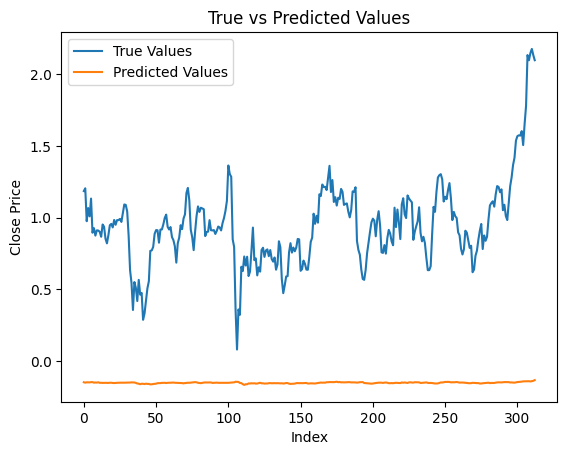

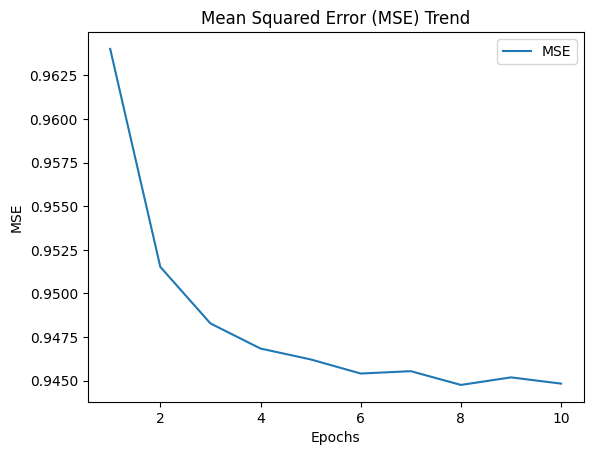

In [8]:
#training
history = model.fit(X_train, y_train,epochs=10, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

Epoch 1/50
42/42 [==============================] - 1s 28ms/step - loss: 0.9444 - val_loss: 1.4110
Epoch 2/50
42/42 [==============================] - 1s 26ms/step - loss: 0.9449 - val_loss: 1.3327
Epoch 3/50
42/42 [==============================] - 1s 25ms/step - loss: 0.9441 - val_loss: 1.3639
Epoch 4/50
42/42 [==============================] - 1s 26ms/step - loss: 0.9438 - val_loss: 1.3705
Epoch 5/50
42/42 [==============================] - 1s 24ms/step - loss: 0.9441 - val_loss: 1.3549
Epoch 6/50
42/42 [==============================] - 1s 28ms/step - loss: 0.9448 - val_loss: 1.3515
Epoch 7/50
42/42 [==============================] - 1s 30ms/step - loss: 0.9439 - val_loss: 1.3666
Epoch 8/50
42/42 [==============================] - 1s 24ms/step - loss: 0.9438 - val_loss: 1.3886
Epoch 9/50
42/42 [==============================] - 1s 33ms/step - loss: 0.9431 - val_loss: 1.3742
Epoch 10/50
42/42 [==============================] - 1s 26ms/step - loss: 0.9437 - val_loss: 1.3334
Epoch 11/

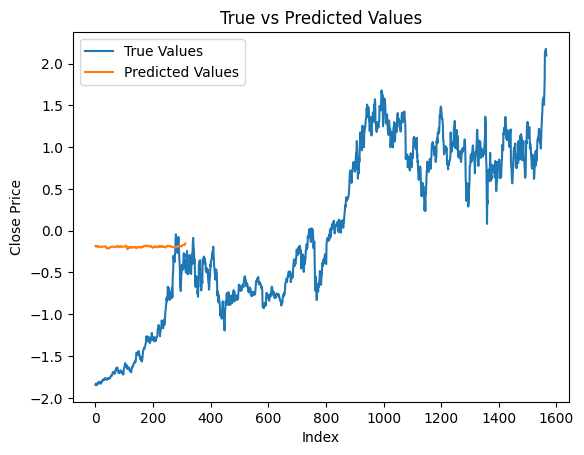

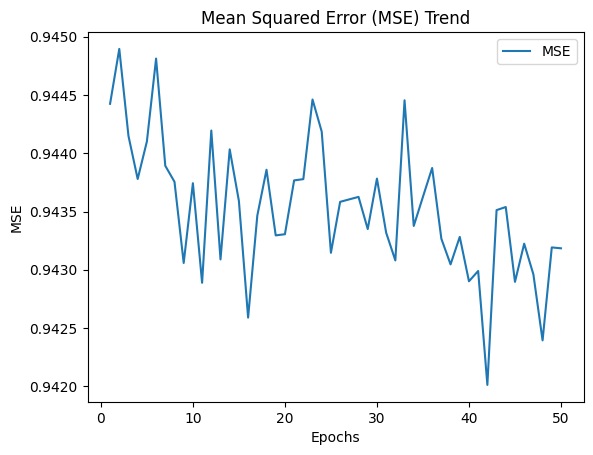

In [9]:
#un'altra prova, aumentando il numero di epoche ma mantenendo lo stesso modello
#training
history = model.fit(X_train, y_train,epochs=50, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(ibm_df['Close'], label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 50)            10400     
                                                                 
 dropout_2 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_3 (Dropout)         (None, 10, 50)            0         
                                                                 
 dense_1 (Dense)             (None, 10, 1)             51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/50
42/42 [==============================] - 6s 38ms/step - loss: 0.9578 - val_loss: 1.2406
Epoch 2/50
42/42 [==============================] - 1s 20ms/step - loss: 0.9455 - val_loss: 1.2148
Epoch 3/50
42/42 [==============================] - 1s 16ms/step - loss: 0.9403 - val_loss: 1.2774
Epoch 4/50
42/42 [==============================] - 1s 16ms/step - loss: 0.9404 - val_loss: 1.3100
Epoch 5/50
42/42 [==============================] - 1s 20ms/step - loss: 0.9396 - val_loss: 1.3416
Epoch 6/50
42/42 [==============================] - 1s 35ms/step - loss: 0.9402 - val_loss: 1.2983
Epoch 7/50
42/42 [==============================] - 2s 40ms/step - loss: 0.9389 - val_loss: 1.3520
Epoch 8/50
42/42 [==============================] - 1s 29ms/step - loss: 0.9385 - val_loss: 1.3181
Epoch 9/50
42/42 [==============================] - 1s 33ms/step - loss: 0.9382 - val_loss: 1.3825
Epoch 10/50
42/42 [==============================] - 1s 33ms/step - loss: 0.9381 - val_loss: 1.3480
Epoch 11/

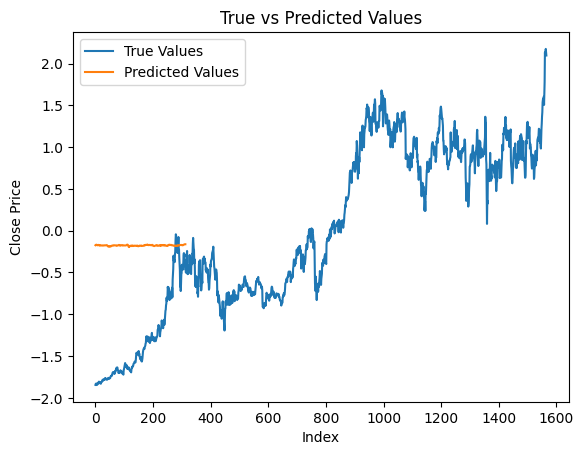

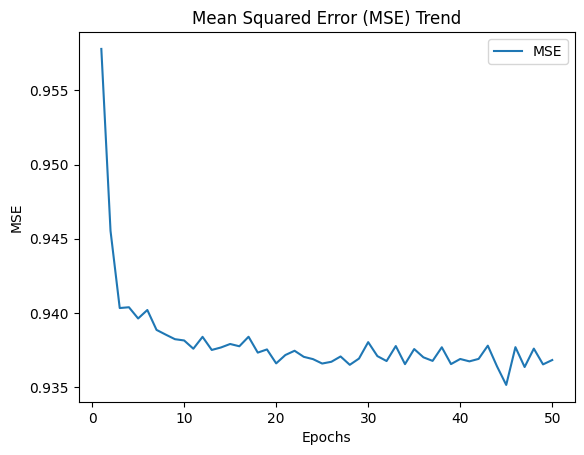

In [10]:
#stesso modello, aumentando la finestra temporale a 10 settimane (50 epoche)
splitlimit = int(len(ibm_df) * 0.8)
ibm_df_train_set = ibm_df.loc[:splitlimit,:]
ibm_df_test_set = ibm_df.loc[splitlimit:,:]

X_train=[]
y_train =[]
df_days=ibm_df_train_set.shape[0]

for x in range(10, df_days): #prendo intanto una finestra di 5 settimane
  X_train.append(ibm_df.loc[x-10:x-1,'Close'])
  y_train.append(ibm_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))


X_test=[]
y_test =[]

for x in range(df_days, ibm_df.shape[0]): #prendo intanto una finestra di 5 settimane
  X_test.append(ibm_df.loc[x-10:x-1,'Close'])
  y_test.append(ibm_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')




#training
history = model.fit(X_train, y_train,epochs=50, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(ibm_df['Close'], label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## SECONDA ARCHITETTURA: inserisco anche gli indicatori in X_train input. 10 epoche, finestra di 5 settimane

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             11200     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 5, 50)             0         
                                                                 
 dense (Dense)               (None, 5, 1)              51        
                                                                 
Total params: 31451 (122.86 KB)
Trainable params: 31451 (122.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/10
33/33 [==============================] - 6s 44ms/step - loss: 0.7165 - val_loss: 1.0227
Epoch 2/10
33/33 [==============================] - 0s 13ms/step - loss: 0.7057 - val_loss: 0.8940
Epoch 3/10
33/33 [==============================] - 0s 11ms/step - loss: 0.7026 - val_loss: 0.8984
Epoch 4/10
33/33 [==============================] - 0s 11ms/step - loss: 0.7023 - val_loss: 0.7781
Epoch 5/10
33/33 [==============================] - 0s 11ms/step - loss: 0.7013 - val_loss: 0.8811
Epoch 6/10
33/33 [==============================] - 0s 13ms/step - loss: 0.7031 - val_loss: 0.8327
Epoch 7/10
33/33 [==============================] - 0s 13ms/step - loss: 0.6987 - val_loss: 0.8471
Epoch 8/10
33/33 [==============================] - 0s 11ms/step - loss: 0.6996 - val_loss: 0.8874
Epoch 9/10
33/33 [==============================] - 0s 11ms/step - loss: 0.6999 - val_loss: 0.8620
Epoch 10/10
5/5 [==============================] - 1s 5ms/step


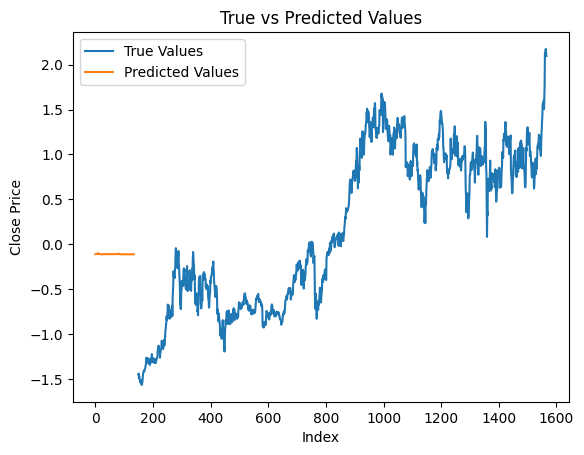

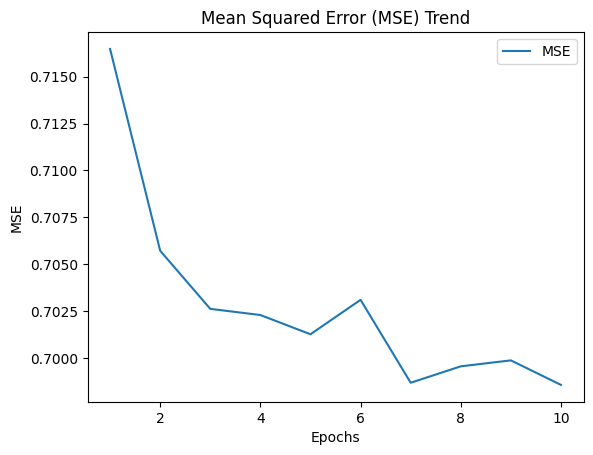

In [4]:
def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],5))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model


ibm_df['RSI']=ta.rsi(ibm_df.Close, length=10)
ibm_df['EMAF']=ta.ema(ibm_df.Close, length=20)
ibm_df['EMAM']=ta.ema(ibm_df.Close, length=100)
ibm_df['EMAS']=ta.ema(ibm_df.Close, length=150)

ibm_df.dropna(inplace=True)
splitlimit = int(len(ibm_df) * 0.8)
ibm_df_train_set = ibm_df.loc[:ibm_df.index[0]+splitlimit,:] ####iloc


X_train=[]
y_train =[]
df_days=ibm_df_train_set.shape[0]

for x in range(ibm_df.index[0]+5, df_days): #prendo intanto una finestra di 5 settimane
  X_train.append(ibm_df.loc[x-5:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_train.append(ibm_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)



X_test=[]
y_test =[]

for x in range(ibm_df.index[0]+df_days, ibm_df.shape[0]): #prendo intanto una finestra di 5 settimane
  X_test.append(ibm_df.loc[x-5:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_test.append(ibm_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test) #non serve convertirlo ancora y_test è già pronto


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')




#training
history = model.fit(X_train, y_train,epochs=10, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(ibm_df['Close'], label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()


##TERZA ARCHITETTURA: performance migliore di 4

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 10, 50)            0         
                                                                 
 dense (Dense)               (None, 10, 1)             51        
                                                                 
Total params: 31451 (122.86 KB)
Trainable params: 31451 (122.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/30
98/98 [==============================] - 8s 34ms/step - loss: 0.7134 - val_loss: 0.7212
Epoch 2/30
98/98 [==============================] - 2s 15ms/step - loss: 0.6960 - val_loss: 0.8632
Epoch 3/30
98/98 [==============================] - 1s 15ms/step - loss: 0.6949 - val_loss: 0.8677
Epoch 4/30
98/98 [==============================] - 1s 13ms/step - loss: 0.6930 - val_loss: 0.6148
Epoch 5/30
98/98 [==============================] - 1s 13ms/step - loss: 0.6920 - val_loss: 0.7017
Epoch 6/30
98/98 [==============================] - 1s 13ms/step - loss: 0.6865 - val_loss: 0.6345
Epoch 7/30
98/98 [==============================] - 1s 13ms/step - loss: 0.6876 - val_loss: 0.6216
Epoch 8/30
98/98 [==============================] - 2s 16ms/step - loss: 0.6909 - val_loss: 0.8323
Epoch 9/30
98/98 [==============================] - 2s 21ms/step - loss: 0.6876 - val_loss: 0.7362
Epoch 10/30
98/98 [==============================] - 2s 17ms/step - loss: 0.6890 - val_loss: 0.7293
Epoch 11/

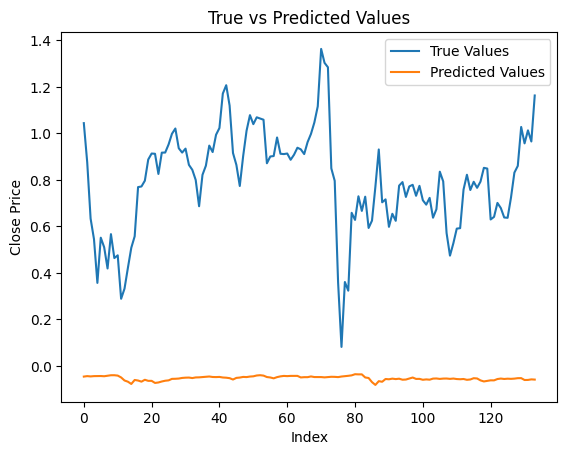

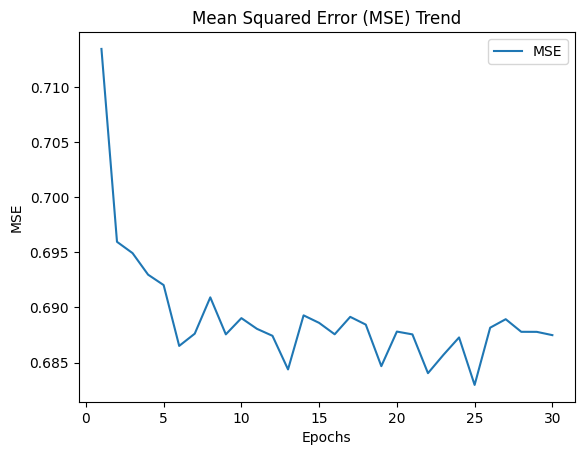

In [6]:
#nuovo modello: inserisco anche gli indicatori in X_train input. 30 epoche, finestra di 10 settimane

def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],5))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model


ibm_df['RSI']=ta.rsi(ibm_df.Close, length=10)
ibm_df['EMAF']=ta.ema(ibm_df.Close, length=20)
ibm_df['EMAM']=ta.ema(ibm_df.Close, length=100)
ibm_df['EMAS']=ta.ema(ibm_df.Close, length=150)

ibm_df.dropna(inplace=True)
splitlimit = int(len(ibm_df) * 0.8)
ibm_df_train_set = ibm_df.loc[:ibm_df.index[0]+splitlimit,:] ####iloc


X_train=[]
y_train =[]
df_days=ibm_df_train_set.shape[0]

for x in range(ibm_df.index[0]+10, df_days): #prendo intanto una finestra di 10 settimane
  X_train.append(ibm_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_train.append(ibm_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)



X_test=[]
y_test =[]

for x in range(ibm_df.index[0]+df_days, ibm_df.shape[0]): #prendo intanto una finestra di 10 settimane
  X_test.append(ibm_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_test.append(ibm_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test) #non serve convertirlo ancora y_test è già pronto


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')




#training
history = model.fit(X_train, y_train,epochs=30, batch_size=10,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## QUARTA ARCHITETTURA: con indicatori, 15 epoche, e più layers.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 10, 50)            0         
                                                                 
 dropout_2 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_3 (Dropout)         (None, 10, 50)            0

None

Epoch 1/15
98/98 [==============================] - 31s 61ms/step - loss: 0.6989 - val_loss: 0.8424
Epoch 2/15
98/98 [==============================] - 4s 38ms/step - loss: 0.6919 - val_loss: 0.7457
Epoch 3/15
98/98 [==============================] - 3s 31ms/step - loss: 0.6902 - val_loss: 0.8712
Epoch 4/15
98/98 [==============================] - 3s 31ms/step - loss: 0.6893 - val_loss: 0.7388
Epoch 5/15
98/98 [==============================] - 3s 35ms/step - loss: 0.6913 - val_loss: 0.8255
Epoch 6/15
98/98 [==============================] - 4s 38ms/step - loss: 0.6908 - val_loss: 0.7569
Epoch 7/15
98/98 [==============================] - 3s 31ms/step - loss: 0.6887 - val_loss: 0.7751
Epoch 8/15
98/98 [==============================] - 3s 33ms/step - loss: 0.6896 - val_loss: 0.8071
Epoch 9/15
98/98 [==============================] - 3s 34ms/step - loss: 0.6889 - val_loss: 0.7987
Epoch 10/15
98/98 [==============================] - 4s 38ms/step - loss: 0.6878 - val_loss: 0.6623
Epoch 11

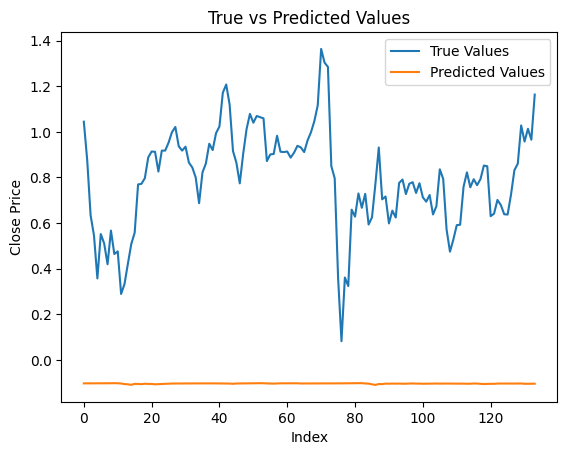

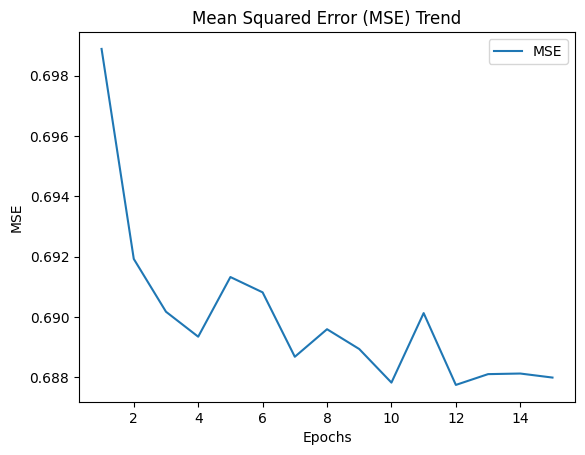

In [6]:
def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],5))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model


ibm_df['RSI']=ta.rsi(ibm_df.Close, length=10)
ibm_df['EMAF']=ta.ema(ibm_df.Close, length=20)
ibm_df['EMAM']=ta.ema(ibm_df.Close, length=100)
ibm_df['EMAS']=ta.ema(ibm_df.Close, length=150)

ibm_df.dropna(inplace=True)
splitlimit = int(len(ibm_df) * 0.8)
ibm_df_train_set = ibm_df.loc[:ibm_df.index[0]+splitlimit,:] ####iloc


X_train=[]
y_train =[]
df_days=ibm_df_train_set.shape[0]

for x in range(ibm_df.index[0]+10, df_days): #prendo intanto una finestra di 10 settimane
  X_train.append(ibm_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_train.append(ibm_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)



X_test=[]
y_test =[]

for x in range(ibm_df.index[0]+df_days, ibm_df.shape[0]): #prendo intanto una finestra di 10 settimane
  X_test.append(ibm_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_test.append(ibm_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test) #non serve convertirlo ancora y_test è già pronto


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')


#training
history = model.fit(X_train, y_train,epochs=15, batch_size=10,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## QUINTA ARCHITETTURA: ritorno verso la quarta, e riduco le units

In [11]:
X_test

array([], dtype=float64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 10)            640       
                                                                 
 dropout (Dropout)           (None, 10, 10)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 10)            840       
                                                                 
 dropout_1 (Dropout)         (None, 10, 10)            0         
                                                                 
 dense (Dense)               (None, 10, 1)             11        
                                                                 
Total params: 1491 (5.82 KB)
Trainable params: 1491 (5.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/30
98/98 [==============================] - 26s 102ms/step - loss: 0.7017 - val_loss: 0.8011
Epoch 2/30
98/98 [==============================] - 3s 27ms/step - loss: 0.6965 - val_loss: 0.8494
Epoch 3/30
98/98 [==============================] - 3s 26ms/step - loss: 0.6927 - val_loss: 0.8464
Epoch 4/30
98/98 [==============================] - 4s 36ms/step - loss: 0.6920 - val_loss: 0.8295
Epoch 5/30
98/98 [==============================] - 3s 28ms/step - loss: 0.6896 - val_loss: 0.7637
Epoch 6/30
98/98 [==============================] - 3s 26ms/step - loss: 0.6904 - val_loss: 0.8008
Epoch 7/30
98/98 [==============================] - 2s 23ms/step - loss: 0.6874 - val_loss: 0.7334
Epoch 8/30
98/98 [==============================] - 1s 13ms/step - loss: 0.6890 - val_loss: 0.7997
Epoch 9/30
98/98 [==============================] - 1s 12ms/step - loss: 0.6862 - val_loss: 0.7456
Epoch 10/30
98/98 [==============================] - 1s 15ms/step - loss: 0.6879 - val_loss: 0.7796
Epoch 1

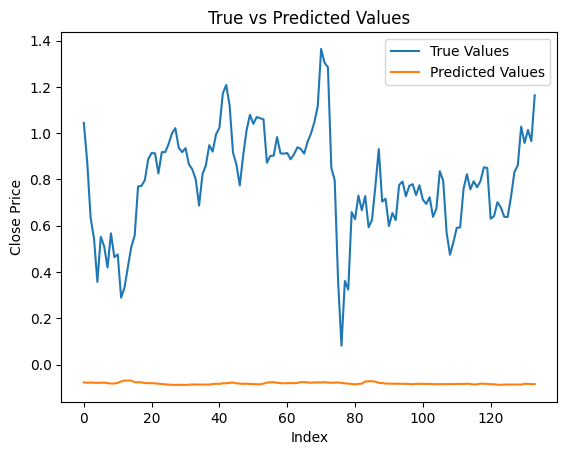

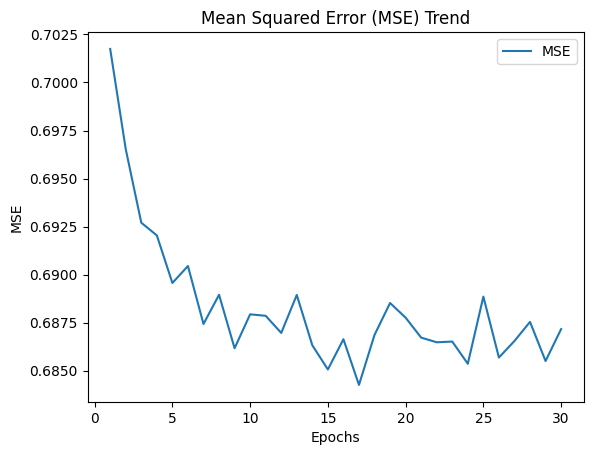

In [6]:
def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=10,
           return_sequences=True,
           input_shape =(X_train.shape[1],5))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=10,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model


ibm_df['RSI']=ta.rsi(ibm_df.Close, length=10)
ibm_df['EMAF']=ta.ema(ibm_df.Close, length=20)
ibm_df['EMAM']=ta.ema(ibm_df.Close, length=100)
ibm_df['EMAS']=ta.ema(ibm_df.Close, length=150)

ibm_df.dropna(inplace=True)
splitlimit = int(len(ibm_df) * 0.8)
ibm_df_train_set = ibm_df.loc[:ibm_df.index[0]+splitlimit,:] ####iloc


X_train=[]
y_train =[]
df_days=ibm_df_train_set.shape[0]

for x in range(ibm_df.index[0]+10, df_days): #prendo intanto una finestra di 10 settimane
  X_train.append(ibm_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_train.append(ibm_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)



X_test=[]
y_test =[]

for x in range(ibm_df.index[0]+df_days, ibm_df.shape[0]): #prendo intanto una finestra di 10 settimane
  X_test.append(ibm_df.loc[x-10:x-1,['Close','RSI','EMAF','EMAM','EMAS']].values)
  y_test.append(ibm_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test) #non serve convertirlo ancora y_test è già pronto


#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')




#training
history = model.fit(X_train, y_train,epochs=30, batch_size=10,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(y_pred[:,0],  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## mistero overfit

Epoch 1/10
45/45 [==============================] - 7s 59ms/step - loss: 0.2497 - val_loss: 1.9168
Epoch 2/10
45/45 [==============================] - 2s 37ms/step - loss: 0.1748 - val_loss: 1.2987
Epoch 3/10
45/45 [==============================] - 2s 53ms/step - loss: 0.1177 - val_loss: 1.0702
Epoch 4/10
45/45 [==============================] - 2s 47ms/step - loss: 0.0924 - val_loss: 0.6410
Epoch 5/10
45/45 [==============================] - 1s 22ms/step - loss: 0.0584 - val_loss: 0.5607
Epoch 6/10
45/45 [==============================] - 1s 31ms/step - loss: 0.0474 - val_loss: 0.3366
Epoch 7/10
45/45 [==============================] - 1s 21ms/step - loss: 0.0293 - val_loss: 0.3693
Epoch 8/10
45/45 [==============================] - 1s 22ms/step - loss: 0.0241 - val_loss: 0.3078
Epoch 9/10
45/45 [==============================] - 1s 21ms/step - loss: 0.0230 - val_loss: 0.2620
Epoch 10/10
21/21 [==============================] - 1s 6ms/step


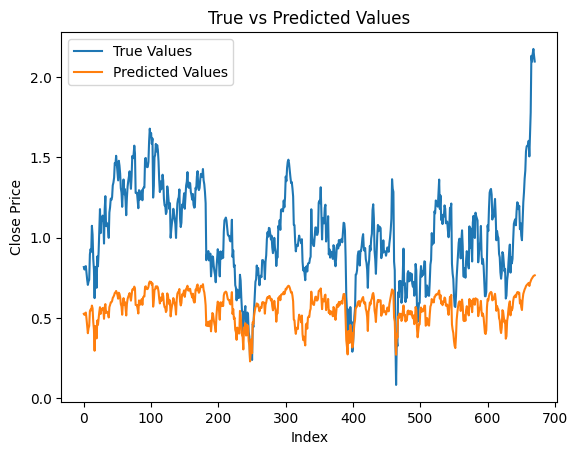

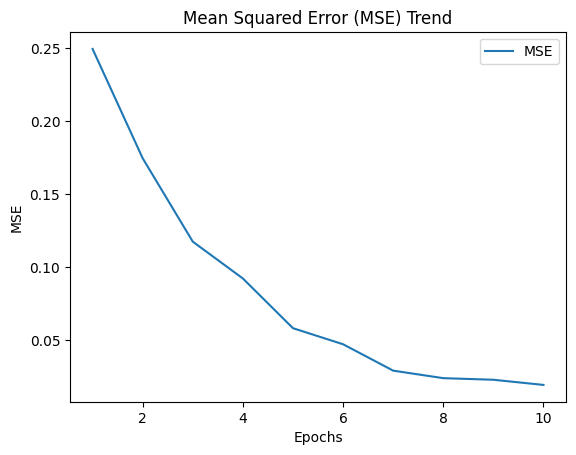

In [18]:
ibm_df['RSI']=ta.rsi(ibm_df.Close, length=10)
ibm_df['EMAF']=ta.ema(ibm_df.Close, length=20)
ibm_df['EMAM']=ta.ema(ibm_df.Close, length=100)
ibm_df['EMAS']=ta.ema(ibm_df.Close, length=150)

ibm_df_set = ibm_df.loc[:, ['Date','Volume','Close','RSI', 'EMAF', 'EMAM','EMAS']].dropna()

splitlimit = int(len(ibm_df_set) * 0.8)
ibm_df_train_set = ibm_df_set.loc[:splitlimit,:] ####iloc
ibm_df_test_set = ibm_df_set.loc[splitlimit:,:]
#ibm_df_train_set.set_index('Date')
#ibm_df_test_set.set_index('Date')

X_train = ibm_df_train_set[['Volume','RSI', 'EMAF', 'EMAM','EMAS']]
#y_train = ibm_df_train_set[['Close']]
X_test = ibm_df_test_set[['Volume','RSI', 'EMAF', 'EMAM','EMAS']]
#y_test = ibm_df_test_set[['Close']]

X_train = np.array(X_train) #Torre: X_train.values lo converte

X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1])) #X_train è una matrice. Verificare che i valori siano messi al posto giusto
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

X_train = np.repeat(X_train, repeats=30, axis=1)
y_train = np.array(ibm_df_train_set[['Close']])

X_test = np.repeat(X_test, repeats=30, axis=1)
y_test = np.array(ibm_df_test_set[['Close']])

model = keras.Sequential()
model.add(keras.layers.LSTM(units = 50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(units=1))
model.compile(optimizer ='adam', loss='mse')


history = model.fit(x=X_train, y=y_train, batch_size=10, epochs=10, validation_data= (X_test,y_test))
y_pred = model.predict(X_test)



# Plot the predicted values
plt.plot(y_test, label='True Values')
plt.plot(np.reshape(y_pred, y_pred.shape[0]),  label='Predicted Values')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()